In [1]:
# !pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

print(os.listdir())

# Импорт библиотек

['requirement.txt', 'main.ipynb', 'tiny-imagenet-200']


Создание переменных с путями к директориям с данными.

In [3]:
train_path = 'tiny-imagenet-200/train/'
test_path = 'tiny-imagenet-200/test/'
val_path = 'tiny-imagenet-200/val/'

 Присваивание меток к каждому изображению

In [4]:
from sklearn.preprocessing import LabelEncoder

labels = os.listdir(train_path)
encoder = LabelEncoder()
encoder.fit(labels)

files_train = []
labels_train = []
for label in labels:
    for filename in os.listdir(train_path + label + '/images/'):
        files_train.append(train_path + label + '/images/' + filename)
        labels_train.append(label)

files_val = []
labels_val = []
for filename in os.listdir(val_path + 'images/'):
    files_val.append(val_path + 'images/' + filename)


val_df = pd.read_csv(val_path + 'val_annotations.txt', sep='\t', names=["File", "Label", "X1", "Y1", "X2", "Y2"], usecols=["File", "Label"])
for f in files_val:
    l = val_df.loc[val_df['File'] == f[len(val_path + 'images/'):]]['Label'].values[0]
    labels_val.append(l)

# Test
files_test = []
for filename in os.listdir(test_path + 'images/'):
    files_test.append(test_path + 'images/' + filename)
    files_test = sorted(files_test)

Посмотрим изображения и выведем метки для каждого

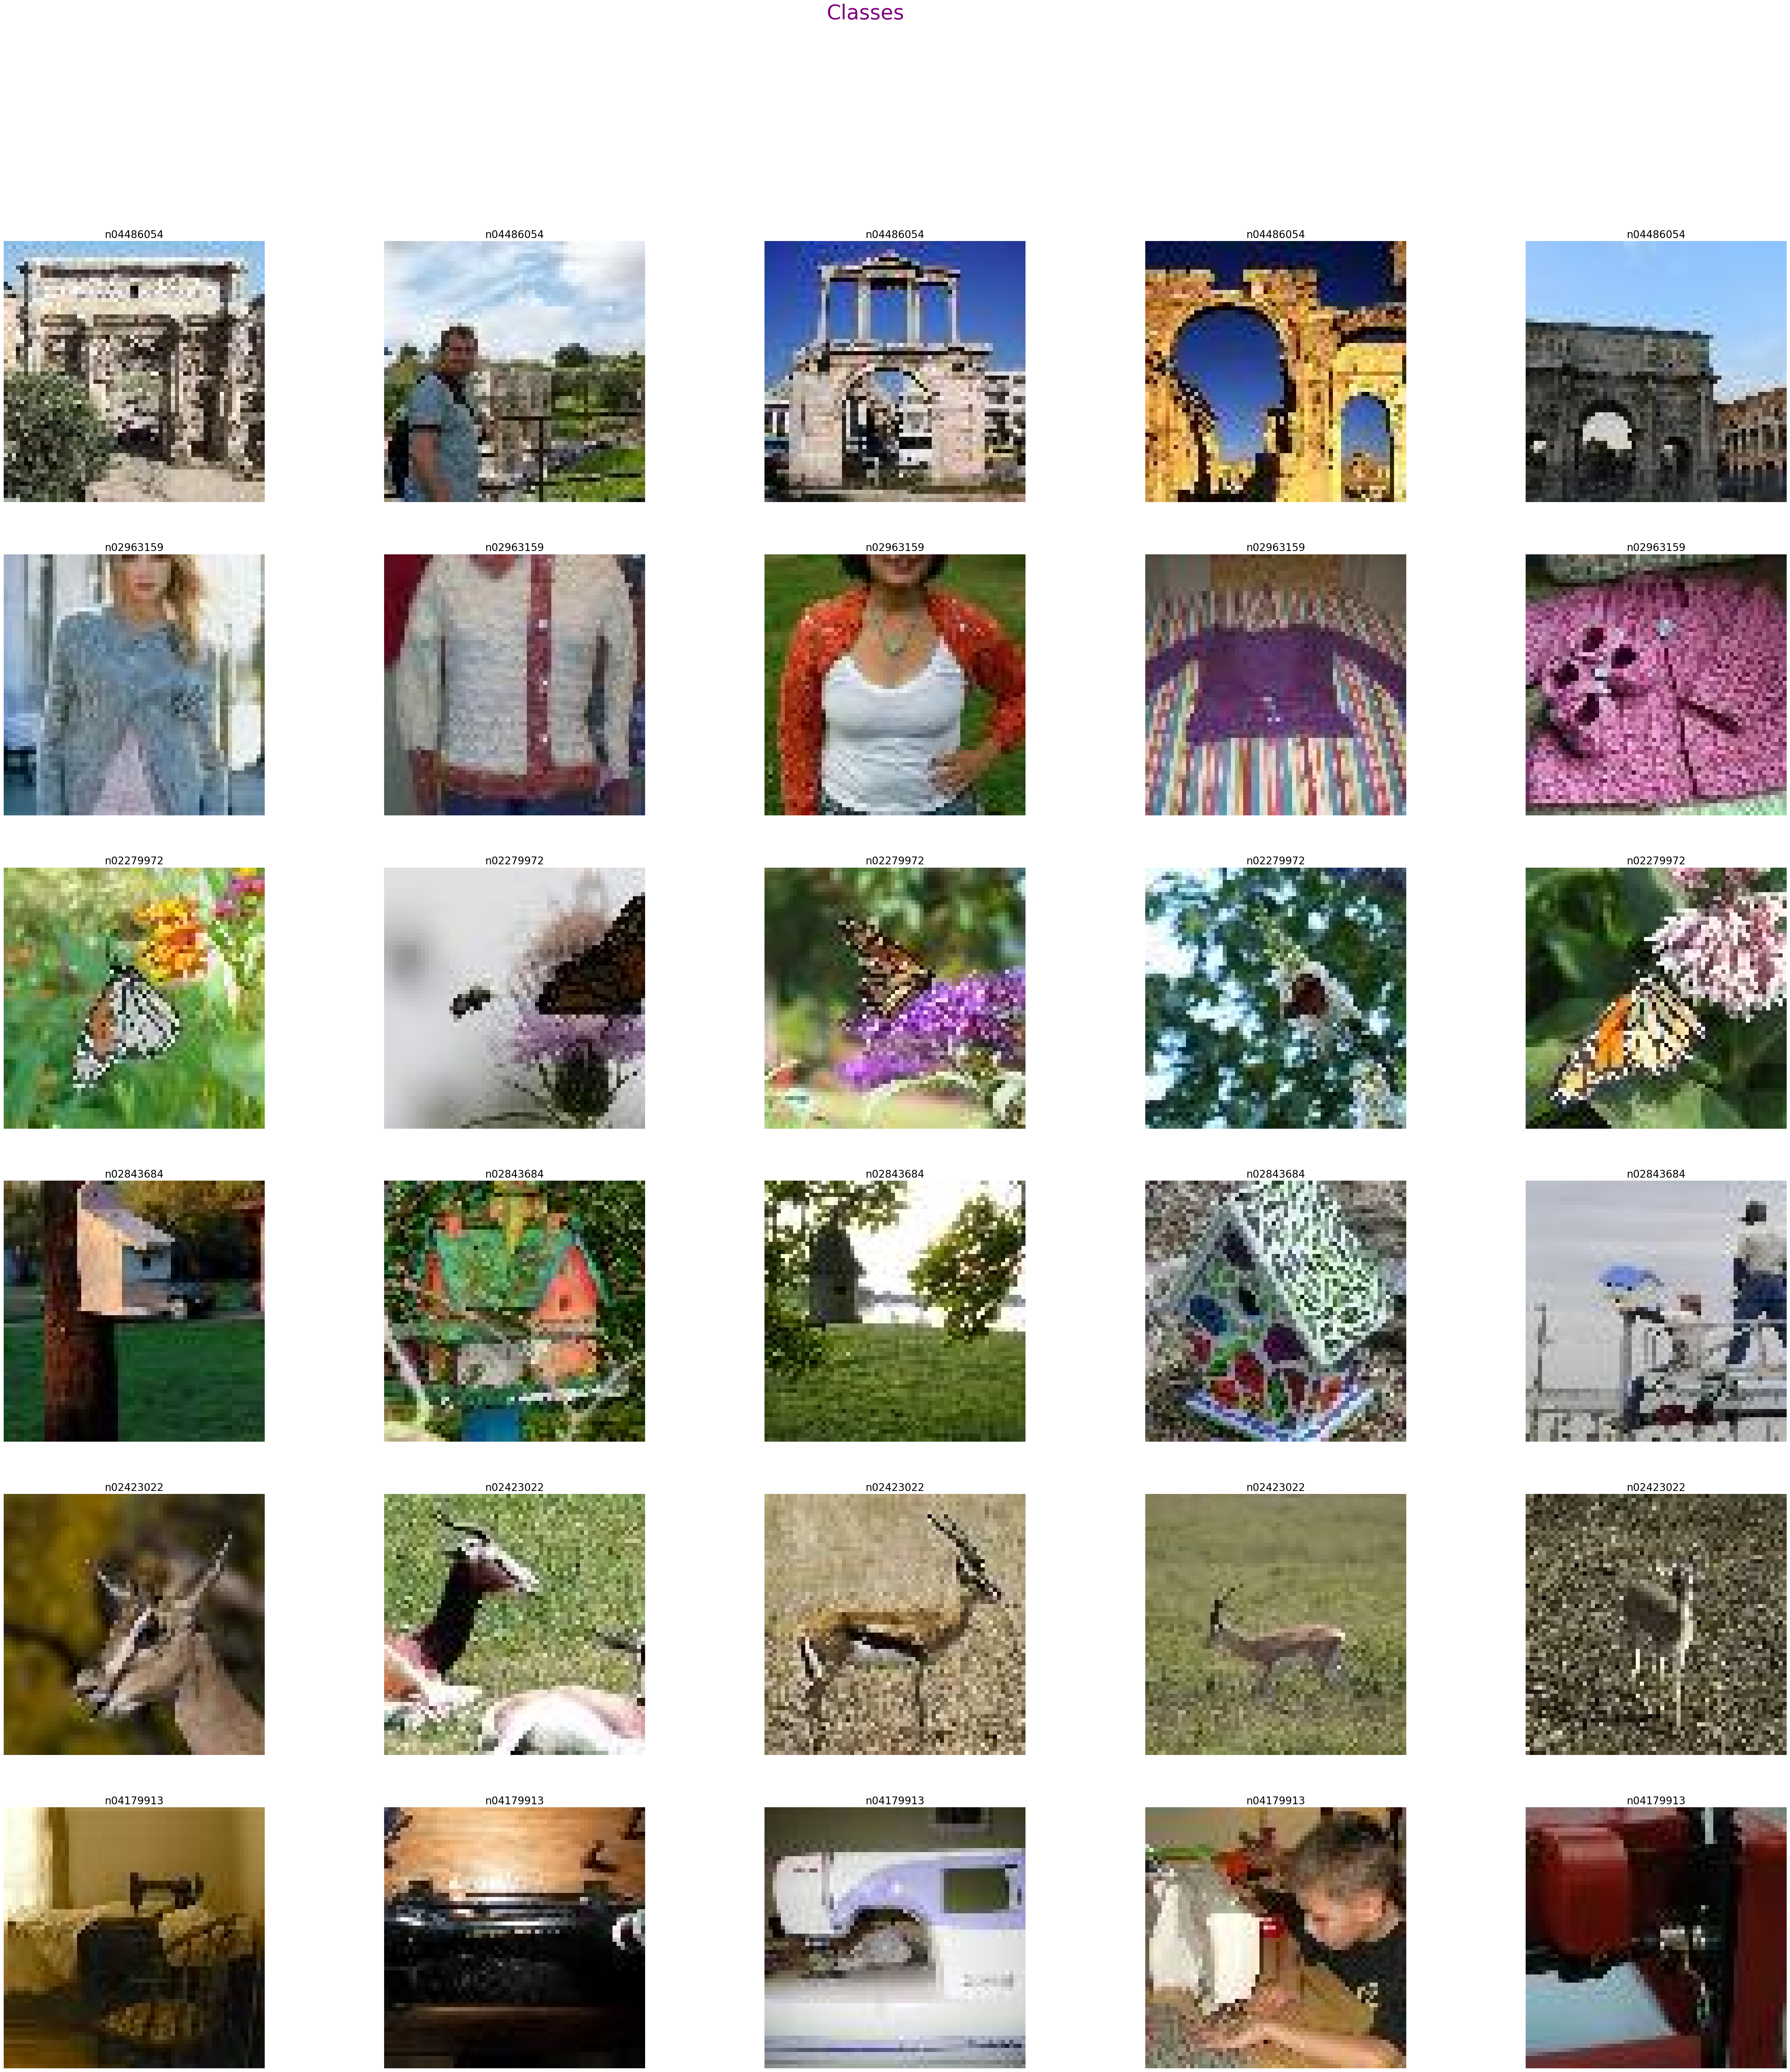

In [5]:
path = train_path


fig, ax = plt.subplots(6, 5, figsize=(64, 64))
fig.suptitle('Classes', color='purple', fontsize=40)

for ax_row, label_name in zip(ax, labels[6:12]):
    im_src = os.path.join(train_path,label_name,'images/') 
    file_names = os.listdir(im_src)
    
    for ax_col, file_name in zip(ax_row, file_names[:5]):
        im_src_file = os.path.join(im_src, file_name)
        image = plt.imread(im_src_file)
        ax_col.axis("off")
        ax_col.imshow(image)
        ax_col.set_title(label_name, fontsize=20)


In [6]:
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

/home/kasperchuk/anaconda3/envs/tensorflow_ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def get_dataset_train_info(path):
    data = {'path': [], 'label': []}
    labels = os.listdir(path)
    for label in labels:
        for filename in os.listdir(path + label + '/images/'):
            if filename.endswith(('.png', '.jpg', '.jpeg', 'JPEG')):
                data['path'].append(path + label + '/images/' + filename)
                data['label'].append(label)            
    df = pd.DataFrame(data)
    return df

In [8]:
def get_dataset_val_info(path):
    data = {'path': [], 'label': []}
    files_val = []
    for filename in os.listdir(path + 'images/'):
        files_val.append(path + 'images/' + filename)
        data['path'].append(path + 'images/' + filename)
    
    
    valdata_df = pd.read_csv(path + 'val_annotations.txt', sep='\t', names=["File", "Label", "X1", "Y1", "X2", "Y2"], usecols=["File", "Label"])
    for f in files_val:
        l = valdata_df.loc[valdata_df['File'] == f[len(path + 'images/'):]]['Label'].values[0]
        data['label'].append(l)
    df = pd.DataFrame(data)
    return df

In [9]:
df_train = get_dataset_train_info(train_path)
df_train.head()

,path,label
0,tiny-imagenet-200/train/n03662601/images/n0366...,n03662601
1,tiny-imagenet-200/train/n03662601/images/n0366...,n03662601
2,tiny-imagenet-200/train/n03662601/images/n0366...,n03662601
3,tiny-imagenet-200/train/n03662601/images/n0366...,n03662601
4,tiny-imagenet-200/train/n03662601/images/n0366...,n03662601


In [10]:
df_val = get_dataset_val_info(val_path)
df_val.head()

,path,label
0,tiny-imagenet-200/val/images/val_2395.JPEG,n04532106
1,tiny-imagenet-200/val/images/val_6031.JPEG,n07753592
2,tiny-imagenet-200/val/images/val_8199.JPEG,n04118538
3,tiny-imagenet-200/val/images/val_8807.JPEG,n02123045
4,tiny-imagenet-200/val/images/val_5304.JPEG,n03584254


In [11]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

Создаeм датасет

In [12]:
class TinyImageNetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self): # Вернет длину датафрейма
        return len(self.dataframe) 

    def __getitem__(self, idx): # Вернет изображение с его меткой
        img_path = self.dataframe.iloc[idx]['path']
        label = self.dataframe.iloc[idx]['label']
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

Создадим последовательность изменений которые будут применяться к каждому изображению из датасета

In [55]:
transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])

    ])

Создадим экземляр датасета

In [56]:
train_dataset = TinyImageNetDataset(df_train, transform)
batch_size = 4
# num_workers = torch.get_num_threads()
num_workers = 0
num_epochs = 5

И загрузим его в DataLoader

In [57]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
import torchvision.models as models

class ResNet50C(nn.Module):
    def __init__(self, num_classes, input_channels):
        super(ResNet50C, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])
        self.resnet[0] = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


num_classes = 200   
input_channels = 3 
model = ResNet50C(num_classes, input_channels)
model = model.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


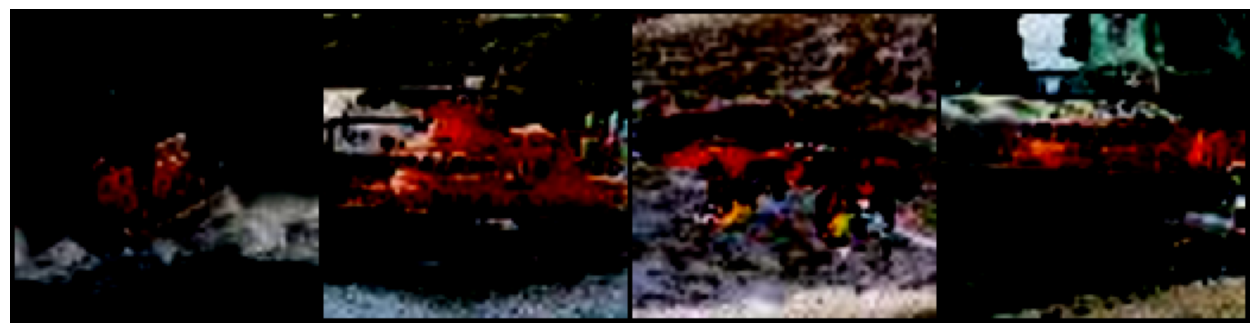

In [59]:
from torchvision.utils import make_grid

for images, _ in train_dataloader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

После нормализации изображения стали странными

In [44]:
import torch.optim as optim
from tqdm import tqdm

In [20]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [21]:
for epoch in range(num_epochs):
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = encoder.fit_transform(labels)
        labels = torch.tensor([labels])
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = loss_func(outputs, labels)

        loss.backward()

        optimizer.step()

        progress_bar.set_postfix({"Loss": loss.item()})

    progress_bar.close()

        # if isinstance(labels, str):
        #     labels = torch.tensor([labels])
     #   labels = torch.tensor([labels])
        
        # print(type(labels))
      #  y_preds = model(images)
       # loss = loss_func(y_preds, labels)
        #optimizer.zero_grad()
        #loss.backward()
        #optimizer.step()

        #progress_bar.set_postfix({"Loss": loss.item()})
    #progress_bar.close()

Epoch 1/5:   0%|          | 0/25000 [00:00<?, ?it/s]/tmp/ipykernel_4904/1942098772.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  labels = torch.tensor([labels])


KeyboardInterrupt: 

Я не успел доделать, т.к. у меня при запуске обучения вылетал редактор кода